In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import pickle

from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.DoubleTensor')

In [0]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [0]:
os.chdir('/content/data/My Drive/DL_Assignment_2')

In [0]:
Data = pd.read_csv('./Data_2/data.csv',delimiter = ',',header = None)
labels = pd.read_csv('./Data_2/label.csv',delimiter = ',',header = None)

X = np.array(Data.iloc[:, 0:784])
Y = np.array(Data.iloc[:, 784])

#train,test splt
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)

In [0]:
x_train.shape[0]

28000

In [0]:
labels

,0
0,Ankle boot
1,T-shirt/top
2,Shirt
3,Dress
4,Trouser


In [0]:
np.unique(Y)

array([0, 1, 2, 3, 4])

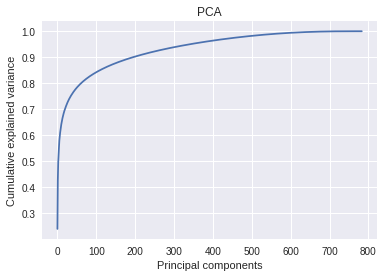

In [0]:
########## PCA ###############
pca = PCA().fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

#plot cumilative explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA')

#decide number of PCs
npca = np.sum(np.cumsum(pca.explained_variance_ratio_) <= 0.99)

In [0]:
npca = np.sum(np.cumsum(pca.explained_variance_ratio_) <= 0.99)

In [0]:
npca

559

In [0]:
def heat_map(actual_train,predicted_train,actual_test,predicted_test):
    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    
    labels = ["Ankle boot","T-shirt/top","Shirt","Dress","Trouser"]
    cm1 =confusion_matrix(actual_train,predicted_train)
    df_cm1 = pd.DataFrame(cm1, index=labels, columns=labels)
                         
    cm2 =confusion_matrix(actual_test,predicted_test)
    df_cm2 = pd.DataFrame(cm2, index=labels, columns=labels)
    
    fig1 = plt.figure(1)
    
    #sn.set(font_scale=1.4)
    sn.heatmap(df_cm1, cmap="YlGnBu",annot=True,fmt='.0f',annot_kws={"size": 12})
    plt.yticks(rotation=0)
    
    fig2 = plt.figure(2)
    #sn.set(font_scale=1.4)
    sn.heatmap(df_cm2, cmap="YlGnBu",annot=True,fmt='.0f',annot_kws={"size": 12})
    plt.yticks(rotation=0)
    
    plt.show()

In [0]:
#### Auto Encoder  #############

class AutoEncoder(nn.Module):
    def __init__(self, D_in, NL, L):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(D_in, NL),
            nn.Tanh(),
            nn.Linear(NL, L),
        )
        self.decoder = nn.Sequential(
            nn.Linear(L, NL),
            nn.Tanh(),
            nn.Linear(NL, D_in),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.double()
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

def AutoEncoderModel(x, input_size, hidden_size, bottle_neck_size):
 
  dtype = torch.int64
  
  print("bottle_neck_size : ",bottle_neck_size)
  print('***********************************')
  x_torch = torch.tensor(x); 
  x_torch = x_torch.to(device)
  

  D_in = input_size
  NL = hidden_size
  L = bottle_neck_size
  MAX_EPOCH = 1000
  BATCH_SIZE = 2048
  LR = 1e-4        
  ERROR_THRESHOLD = 1e-4

  train_loader = torch.utils.data.DataLoader(x_torch, batch_size = BATCH_SIZE, shuffle=False)


  AE = AutoEncoder(D_in, NL, L)
  AE = AE.to(device)
  optimizer = torch.optim.Adam(AE.parameters(), lr=LR)
  loss_fn = torch.nn.MSELoss(reduction='mean')
  error_train = []
  for epoch in range(MAX_EPOCH):
      batch_loss = []
      for data in train_loader: 
        
        data = data.double()

        encoded, decoded = AE(data)
        decoded = decoded.double()

        loss = loss_fn(decoded, data)

        batch_loss.append(loss.item())
        optimizer.zero_grad()               
        loss.backward()                     
        optimizer.step()  
       
      mean_batch_loss = np.mean(batch_loss)
      del batch_loss
      if epoch % 100 == 0:
          print(epoch, mean_batch_loss.item())    
      error_train.append(mean_batch_loss.item())

      if  epoch>= 5 and abs(error_train[epoch-4] - error_train[epoch]) <= ERROR_THRESHOLD:
        print('Reached threshold')
        break     
  plt.plot(error_train, color = 'g', label = 'reconstruction error')
  plt.legend()

  plt.xlabel('epochs')
  plt.ylabel('MSE')
  plt.title('MSE vs epochs')
  plt.show()
  
  print('***********************************')
  print('number of epochs:', len(error_train))
  print('reconstruction error: ', error_train[-1])
  print('***********************************')
  print('***********************************')
  
  x_ae, _ = AE(x_torch)
  x_ae = x_ae.cpu().detach()
  
  
  return AE,x_ae

In [0]:
def Stacked_AE_Models(x_train,bottle_neck_size):
  
  D_in = x_train.shape[1]
  
  D_in_1 = D_in
  D_in_2 = bottle_neck_size
  D_in_3 = int((D_in_2)*0.7*0.7)
  
  AE1, feat1 = AutoEncoderModel(x_train, D_in_1, int(D_in_1*0.7), bottle_neck_size)
  AE2, feat2 = AutoEncoderModel(feat1, D_in_2, int(D_in_2*0.7), D_in_3)
  AE3, feat3 = AutoEncoderModel(feat2, D_in_3, int(D_in_3*0.7), int(D_in_3*0.7*0.7))
  
  
  
  return AE1,AE2,AE3,feat3, int(D_in_3*0.7*0.7) 

def Stacked_AEs(bottle_neck_size):
  
  D_in = 784
  
  D_in_1 = D_in
  D_in_2 = bottle_neck_size
  D_in_3 = int((D_in_2)*0.7*0.7)
  
  AE1 = AutoEncoder(D_in_1, int(D_in_1*0.7), bottle_neck_size)
  AE2 = AutoEncoder(D_in_2, int(D_in_2*0.7), D_in_3)
  AE3 = AutoEncoder(D_in_3, int(D_in_3*0.7), int(D_in_3*0.7*0.7))
  
  
  return AE1, D_in_2, AE2, D_in_3, AE3, int(D_in_3*0.7*0.7) 

In [0]:
################# MLFFNN  #########################
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

def StackedAE_MLFFNN(x_train, y_train, x_test, y_test, learning_rate, max_epoch, error_threshold, bottle_neck_size): 
  
  dtype = torch.int64

  #make torch tensors 
  x_train_torch = torch.tensor(x_train,dtype=torch.double); 
  x_train_torch = x_train_torch.to(device)
  y_train_torch = torch.tensor(y_train, dtype=dtype)
  y_train_torch = y_train_torch.to(device)
  
  x_test_torch = torch.tensor(x_test,dtype=torch.double); 
  x_test_torch = x_test_torch.to(device)
  y_test_torch = torch.tensor(y_test, dtype=dtype)
  y_test_torch = y_test_torch.to(device)
  
  D_IN = x_train.shape[1]
  BOTTLENECK_SIZE = bottle_neck_size
  D_OUT = 5
  LEARNING_RATE = learning_rate
  MAX_EPOCH = max_epoch
  THRESHOLD = error_threshold
  
  AE1,AE2,AE3,feature_train_ae, bottle_neck3 = Stacked_AE_Models(x_train,bottle_neck_size = BOTTLENECK_SIZE)
  
  ae1, _ = AE1(x_test_torch)
  ae2, _ = AE2(ae1)
  feature_test_ae, _ = AE3(ae2)
  
  feature_train_ae_torch = torch.tensor(feature_train_ae); 
  feature_train_ae_torch = feature_train_ae_torch.to(device)
  
  feature_test_ae_torch = torch.tensor(feature_test_ae); 
  feature_test_ae_torch = feature_test_ae_torch.to(device)
  
  
  ##################################
  
  ##############################
  
  train_loader = torch.utils.data.DataLoader(ConcatDataset(x_train_torch,y_train_torch), batch_size= 2048, shuffle=False)
  
  classifier = torch.nn.Sequential(AE1.encoder,AE2.encoder,AE3.encoder,torch.nn.Linear(bottle_neck3, 5),
                                   torch.nn.Softmax())
         

  classifier = classifier.to(device)
  loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
  optimizer = torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
  error_train = []
  accuracy = []
  ##### Training ##############
  for epoch in range(MAX_EPOCH):
    batch_loss = []
    for data in train_loader: 
    
    
      y_pred_train = classifier(x_train_torch)        
      loss_train = loss_fn(y_pred_train, y_train_torch)
      batch_loss.append(loss_train.item())
      
      optimizer.zero_grad()
      loss_train.backward()
      optimizer.step()
     
    ##########
    y_pred_test = classifier(x_test_torch) 
    prediction_test = y_pred_test.cpu().detach().numpy()
    prediction_test = prediction_test.argmax(axis = 1)
    acc = accuracy_score(y_test, prediction_test)
    accuracy.append(acc.item())
    ###############
    mean_batch_loss = np.mean(batch_loss)
    del batch_loss
    if epoch % 50 == 0:
        print(epoch, mean_batch_loss.item())    
    error_train.append(mean_batch_loss.item())

    #early stopping criteria
    if epoch >= 5 and abs(error_train[epoch-1] - error_train[epoch]) <= THRESHOLD:
      print('Reached threshold')
      break

  
  
  print('number of epochs:', len(error_train))
  print('train error: ', error_train[-1])
  #test accuracy
  y_pred_test = classifier(x_test_torch)        
  loss_test = loss_fn(y_pred_test, y_test_torch)
  test_error = loss_test.cpu().item()
  print('test error: ', test_error)
  
  #fig1 = plt.figure(1)
  plt.plot(error_train, color = 'b', label = 'training error pre trained')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('cross entropy')
  plt.title('cross entropy vs epochs')
  plt.show()
  
  #fig2 = plt.figure(2)
  
  prediction_train = y_pred_train.cpu().detach().numpy()
  prediction_train = prediction_train.argmax(axis = 1)
  acc = accuracy_score(y_train, prediction_train)
  fig3 = plt.figure(3)
  print('Train accuracy:', acc)

  
  ##################
  prediction_test = y_pred_test.cpu().detach().numpy()
  prediction_test = prediction_test.argmax(axis = 1)
  acc = accuracy_score(y_test, prediction_test)
  print('Test accuracy:', acc)

  #Confusion matrix
  heat_map(y_train, prediction_train, y_test, prediction_test)

  return classifier,accuracy,error_train

n_iter:  1
bottle_neck_size :  500
***********************************
0 0.22939114458292847
100 0.04267472699428069
200 0.029576576055686542
300 0.022633614333260863
400 0.01726515483235304
500 0.013137432261033243
Reached threshold


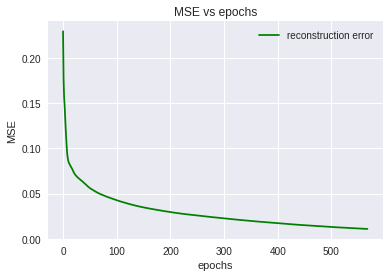

***********************************
number of epochs: 568
reconstruction error:  0.010985662719154899
***********************************
***********************************
bottle_neck_size :  244
***********************************


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0 0.9304865676062954
100 0.5103831211509865
200 0.4662431537170723
300 0.4319004646007259
400 0.41299614695965264
500 0.40215543973249607
600 0.39702496970149753
Reached threshold


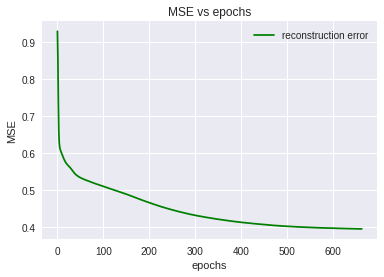

***********************************
number of epochs: 664
reconstruction error:  0.39507369201612325
***********************************
***********************************
bottle_neck_size :  119
***********************************
0 0.6467113861033784
100 0.37602176904930446
200 0.3509190722071546
300 0.3104565563746697
400 0.28392575734533837
500 0.2668159237952309
600 0.25465788030402475
700 0.24592661724924622
800 0.2398143057978977
900 0.23523451326678108


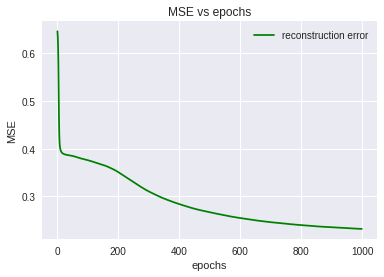

***********************************
number of epochs: 1000
reconstruction error:  0.2318352494424098
***********************************
***********************************


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.3770006420502328
Reached threshold
number of epochs: 39
train error:  0.9815729295639006
test error:  1.0097233203043199


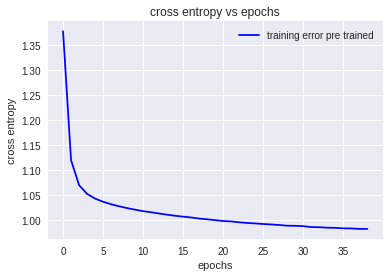

Train accuracy: 0.9267142857142857
Test accuracy: 0.8945714285714286


<Figure size 432x288 with 0 Axes>

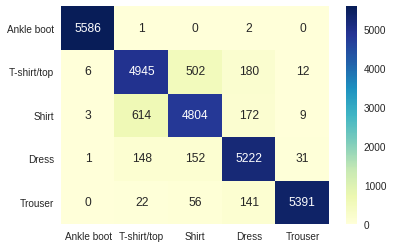

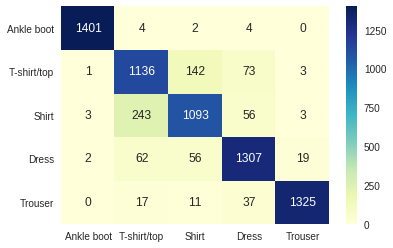

n_iter:  2
bottle_neck_size :  450
***********************************
0 0.2298770003697959
100 0.04316738965709855
200 0.030157252736223
300 0.023516079915681474
400 0.018159006999359135
500 0.013894073412581111
Reached threshold


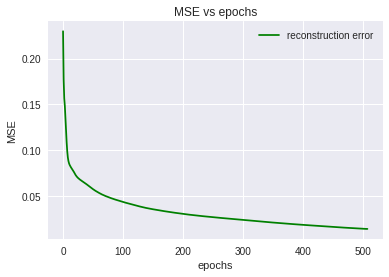

***********************************
number of epochs: 508
reconstruction error:  0.013723840721241781
***********************************
***********************************
bottle_neck_size :  220
***********************************
0 1.0430490089723163
100 0.588790713841983
200 0.5408118071634231
300 0.5056973843145108
400 0.4856138980227477
500 0.47540631299654434
600 0.4706929459162819
Reached threshold


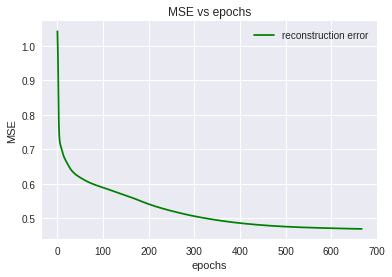

***********************************
number of epochs: 668
reconstruction error:  0.4687403065478679
***********************************
***********************************
bottle_neck_size :  107
***********************************
0 0.6665000414370129
100 0.3863147175274556
200 0.3602046338676544
300 0.32096040266867737
400 0.29281773423037144
500 0.2753227310667631
600 0.26312503669167375
700 0.2542364726456335
800 0.24752051098997555
900 0.2420438079581886


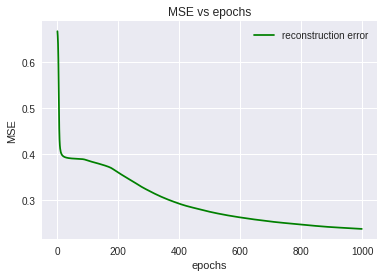

***********************************
number of epochs: 1000
reconstruction error:  0.23820455365644833
***********************************
***********************************
0 1.3880290885868827
Reached threshold
number of epochs: 38
train error:  0.9814078049085018
test error:  1.0108812297115142


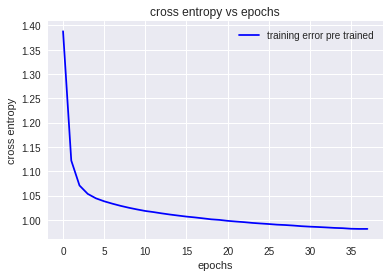

Train accuracy: 0.9277142857142857
Test accuracy: 0.8928571428571429


<Figure size 432x288 with 0 Axes>

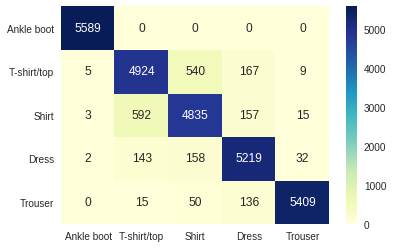

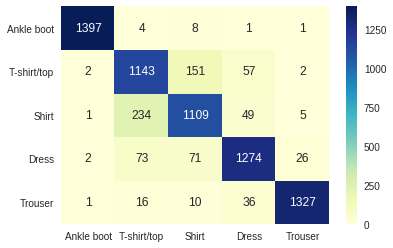

n_iter:  3
bottle_neck_size :  400
***********************************
0 0.231293247122825
100 0.04321579957752421
200 0.03038331227868827
300 0.02327372762571195
400 0.01799866580053531
Reached threshold


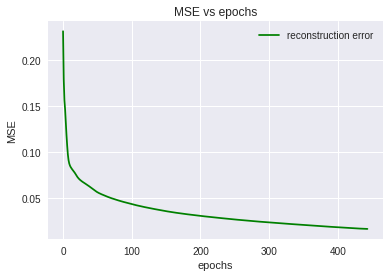

***********************************
number of epochs: 444
reconstruction error:  0.016204241339306813
***********************************
***********************************
bottle_neck_size :  196
***********************************
0 1.2347417814915125
100 0.7335043849873009
200 0.6761353913710046
300 0.6356268362968152
400 0.6123274455559041
500 0.6001635123851836
600 0.5948616381490964
700 0.5917581987016122
Reached threshold


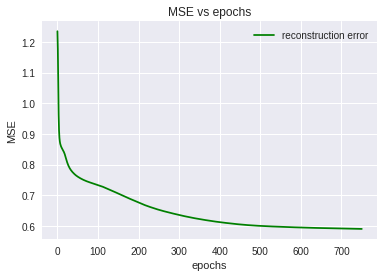

***********************************
number of epochs: 751
reconstruction error:  0.5903178958557341
***********************************
***********************************
bottle_neck_size :  96
***********************************
0 0.6332613505400927
100 0.3574307715608418
200 0.3334148642354186
300 0.29581656608046825
400 0.2697533072916631
500 0.2527965146776399
600 0.24097624397410194
700 0.23186601141696497
800 0.22525169097524925
900 0.2201373670260247
Reached threshold


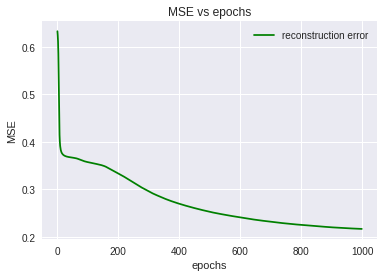

***********************************
number of epochs: 1000
reconstruction error:  0.21675576402462382
***********************************
***********************************
0 1.3938396262365662
Reached threshold
number of epochs: 50
train error:  0.9763136222919755
test error:  1.0092234712516952


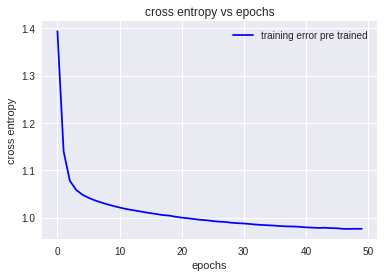

Train accuracy: 0.9306428571428571
Test accuracy: 0.8947142857142857


<Figure size 432x288 with 0 Axes>

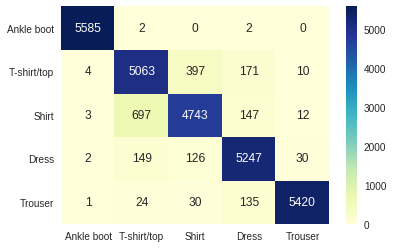

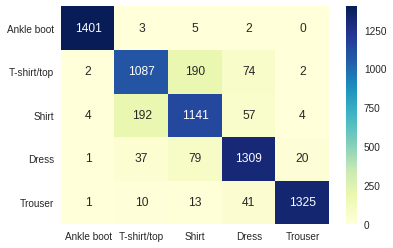

n_iter:  4
bottle_neck_size :  350
***********************************
0 0.23137197680325358
100 0.043701854974269524
200 0.03097414330044626
300 0.024194400381718488
400 0.019074770225413398
500 0.015009252124980417
Reached threshold


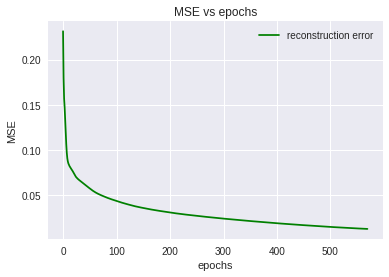

***********************************
number of epochs: 570
reconstruction error:  0.01280541386368411
***********************************
***********************************
bottle_neck_size :  171
***********************************
0 1.16197979443845
100 0.6974913698428606
200 0.6523205183743009
300 0.6093541988641457
400 0.582348716760695
500 0.5658696756585073
600 0.5560932926775035
700 0.5503917806220827
800 0.5468314274259192
Reached threshold


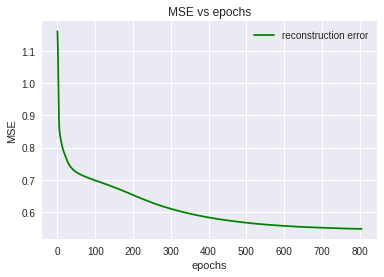

***********************************
number of epochs: 806
reconstruction error:  0.546706080731181
***********************************
***********************************
bottle_neck_size :  83
***********************************
0 0.6403716415895959
Reached threshold


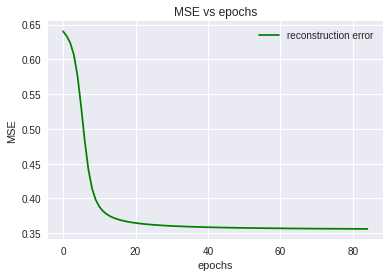

***********************************
number of epochs: 85
reconstruction error:  0.3562117198349125
***********************************
***********************************
0 1.4952071548194417
Reached threshold
number of epochs: 43
train error:  0.9823061293335072
test error:  1.0098080165581202


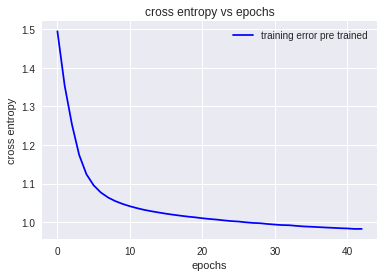

Train accuracy: 0.9286785714285715
Test accuracy: 0.8941428571428571


<Figure size 432x288 with 0 Axes>

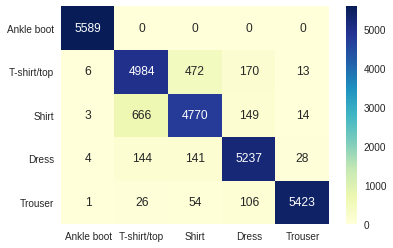

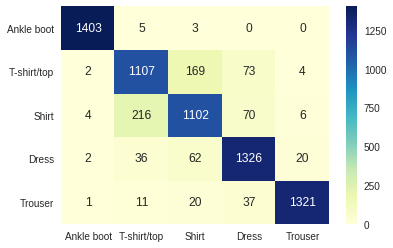

n_iter:  5
bottle_neck_size :  300
***********************************
0 0.2326585663738816
100 0.044200054940225796
200 0.03134440499113425
300 0.024556605149995657
400 0.01947522185623926
500 0.015441081243866214
Reached threshold


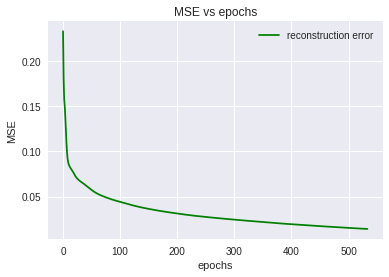

***********************************
number of epochs: 534
reconstruction error:  0.014322486736118798
***********************************
***********************************
bottle_neck_size :  147
***********************************
0 1.345420423000334
100 0.8389258046142652
200 0.7878471564020535
300 0.7444842668087068
400 0.7148093894114522
500 0.6962516889960995
600 0.6837882206419629
700 0.6758437479649858
800 0.6713499735253329
Reached threshold


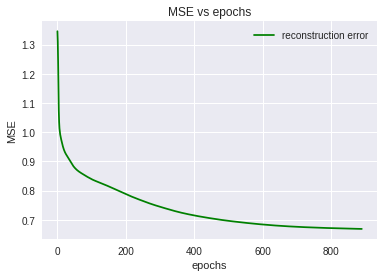

***********************************
number of epochs: 891
reconstruction error:  0.66862711069633
***********************************
***********************************
bottle_neck_size :  72
***********************************
0 0.603823190629923
Reached threshold


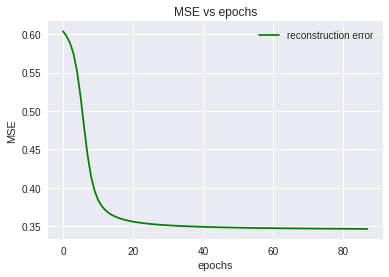

***********************************
number of epochs: 88
reconstruction error:  0.3464400065977524
***********************************
***********************************
0 1.5028806029752304
50 0.9765230683783627
Reached threshold
number of epochs: 62
train error:  0.9716800559599006
test error:  1.0087100803761926


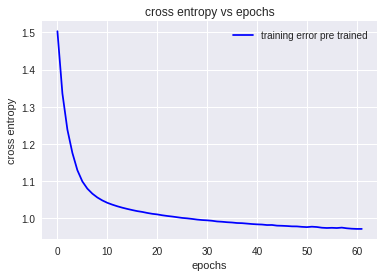

Train accuracy: 0.9359285714285714
Test accuracy: 0.8955714285714286


<Figure size 432x288 with 0 Axes>

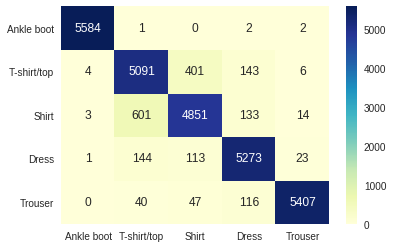

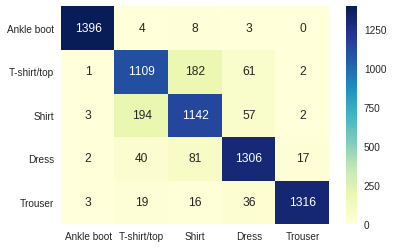

n_iter:  6
bottle_neck_size :  250
***********************************
0 0.23253394989248014
100 0.0443324127855423
200 0.031517941062186874
300 0.02470450945056877
400 0.01963476205887344
500 0.015771012470100394
Reached threshold


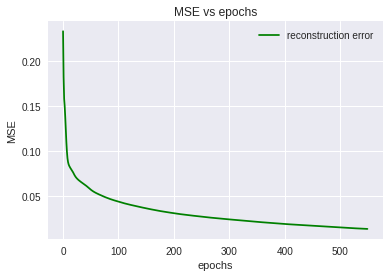

***********************************
number of epochs: 550
reconstruction error:  0.014193144507944257
***********************************
***********************************
bottle_neck_size :  122
***********************************
0 1.555396944432125
100 1.0345724435316268
200 0.9799677017027237
300 0.9273805023175984
400 0.8908233684496798
500 0.8662085341540553
600 0.8495388677668724
700 0.8375725463915922
800 0.829324513513719
900 0.8234598398168284


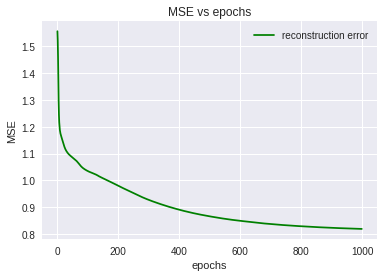

***********************************
number of epochs: 1000
reconstruction error:  0.8193917048204435
***********************************
***********************************
bottle_neck_size :  59
***********************************
0 0.6581539321677147
100 0.3671170458224803
200 0.3524511324424077
300 0.33548847821968225
400 0.31134635904852404
500 0.2927368950282818
600 0.2801175213054973
700 0.27128676597640705
800 0.26465862026186154
900 0.2587320544942869


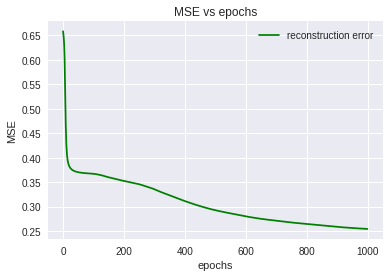

***********************************
number of epochs: 1000
reconstruction error:  0.25455739849277564
***********************************
***********************************
0 1.4222271373786255
50 0.9763954438217466
Reached threshold
number of epochs: 55
train error:  0.9747425057342187
test error:  1.0043882490510387


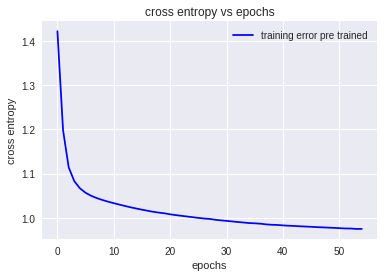

Train accuracy: 0.9336785714285715
Test accuracy: 0.8988571428571429


<Figure size 432x288 with 0 Axes>

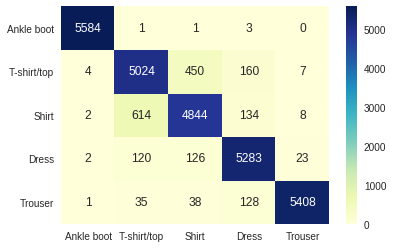

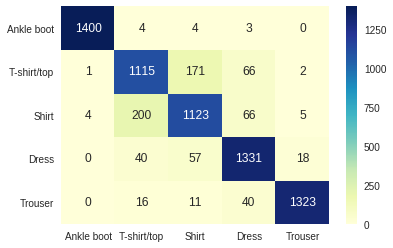

n_iter:  7
bottle_neck_size :  200
***********************************
0 0.23376627896577515
100 0.04512686498118129
200 0.032090182618559775
300 0.02558528037308163
400 0.020864538634621017
500 0.01703299772220875
Reached threshold


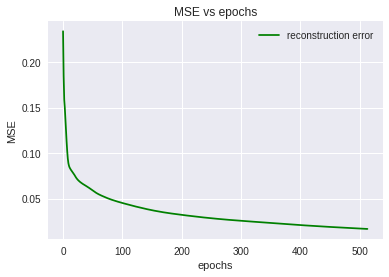

***********************************
number of epochs: 514
reconstruction error:  0.01665647866450142
***********************************
***********************************
bottle_neck_size :  98
***********************************
0 1.8607460964344913
100 1.2747281937661115
200 1.215955861332217
300 1.162132963628545
400 1.1221751647396483
500 1.094939011353753
600 1.0753386413888446
700 1.0616654686603473
800 1.052361656719597
900 1.0451751702935184


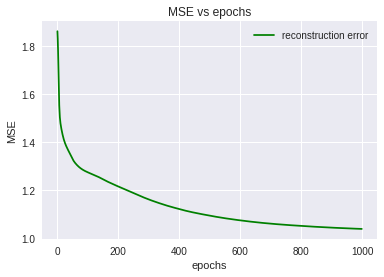

***********************************
number of epochs: 1000
reconstruction error:  1.039834412713167
***********************************
***********************************
bottle_neck_size :  48
***********************************
0 0.7005650753666676
100 0.42730868061253197
200 0.40380477814268284
300 0.37366988771394066
400 0.349205901842785
500 0.32851873442592455
600 0.31456612613307844
700 0.30519874142728154
800 0.2977163711784335
900 0.2915262547806636


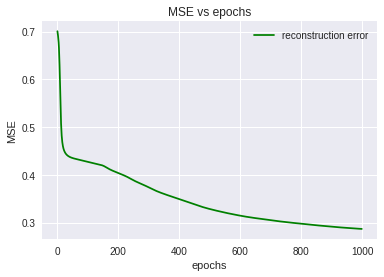

***********************************
number of epochs: 1000
reconstruction error:  0.2868599820267058
***********************************
***********************************
0 1.4811485297569615
Reached threshold
number of epochs: 50
train error:  0.9776906698269768
test error:  1.004189349598788


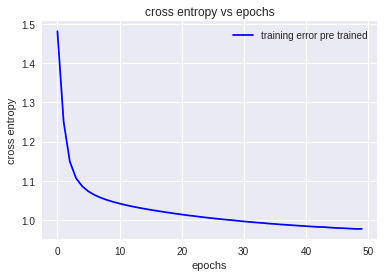

Train accuracy: 0.9318214285714286
Test accuracy: 0.8997142857142857


<Figure size 432x288 with 0 Axes>

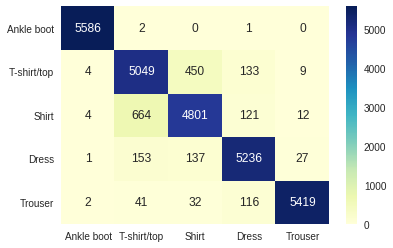

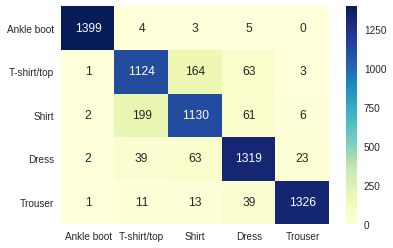

n_iter:  8
bottle_neck_size :  150
***********************************
0 0.23266731582848577
100 0.04453348116112056
200 0.03271149174325148
300 0.02626744150887602
400 0.02169069507670194
500 0.01785573158823187
Reached threshold


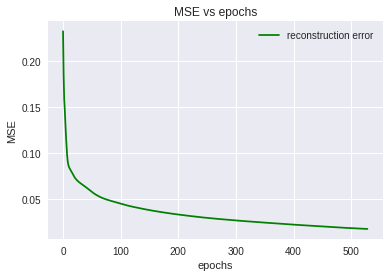

***********************************
number of epochs: 529
reconstruction error:  0.01702555436889573
***********************************
***********************************
bottle_neck_size :  73
***********************************
0 2.302005615752535
100 1.644546855039162
200 1.5760460857547203
300 1.5337184980688296
400 1.4895739019555891
500 1.4547554783806278
600 1.4301218591971594
700 1.4118644736445787
800 1.3971624361790014
900 1.3856478106297556


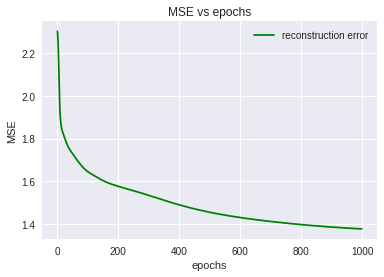

***********************************
number of epochs: 1000
reconstruction error:  1.3769473739629892
***********************************
***********************************
bottle_neck_size :  35
***********************************
0 0.9495811135626061
100 0.6264940093773828
Reached threshold


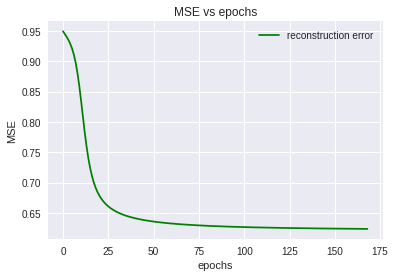

***********************************
number of epochs: 169
reconstruction error:  0.6235065220259043
***********************************
***********************************
0 1.5342995405854751
50 0.9896090125145157
Reached threshold
number of epochs: 62
train error:  0.9809028527154833
test error:  1.0094782115280898


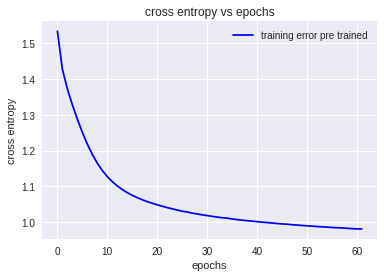

Train accuracy: 0.9329285714285714
Test accuracy: 0.8975714285714286


<Figure size 432x288 with 0 Axes>

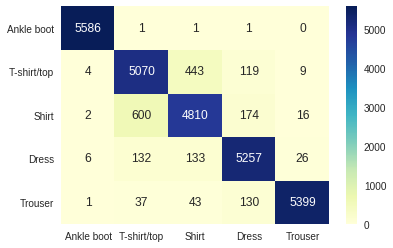

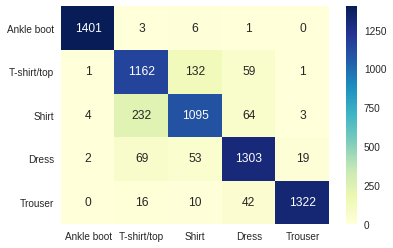

n_iter:  9
bottle_neck_size :  100
***********************************
0 0.23496532703955778
100 0.045200991512578295
200 0.033179314129238205
300 0.02692029370736087
400 0.02247240589132318
500 0.019039515284845678
Reached threshold


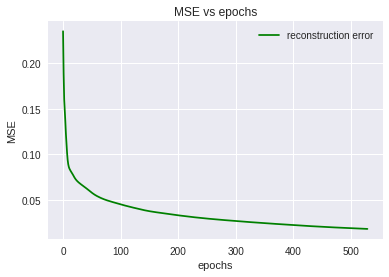

***********************************
number of epochs: 530
reconstruction error:  0.01824785018437463
***********************************
***********************************
bottle_neck_size :  49
***********************************
0 3.203207359974048
100 2.4884272275459614
200 2.4016539938146613
300 2.341703823380237
400 2.296168798760301
500 2.259266290726556
600 2.2250758470856726
700 2.1989244971665234
800 2.1784245649385774
900 2.161393297037018


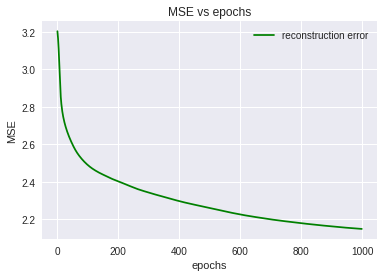

***********************************
number of epochs: 1000
reconstruction error:  2.1478482294805894
***********************************
***********************************
bottle_neck_size :  24
***********************************
0 1.1307540176474122
100 0.8087633191373333
200 0.7451061188091127
300 0.711258761423335
400 0.6758372383100867
500 0.648741331061234
600 0.6286138958820808
700 0.6135559124011555
800 0.601049692742917
900 0.587977120618384


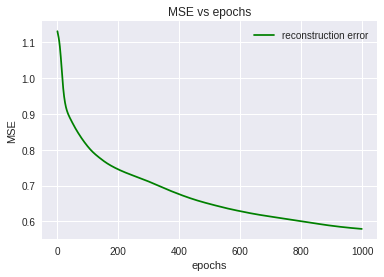

***********************************
number of epochs: 1000
reconstruction error:  0.5791585259557026
***********************************
***********************************
0 1.5117657576480568
50 0.9850616387813566
Reached threshold
number of epochs: 88
train error:  0.9635338496741488
test error:  1.0040445578849397


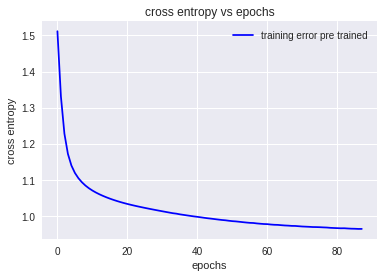

Train accuracy: 0.9455
Test accuracy: 0.9002857142857142


<Figure size 432x288 with 0 Axes>

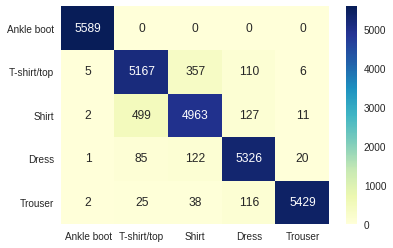

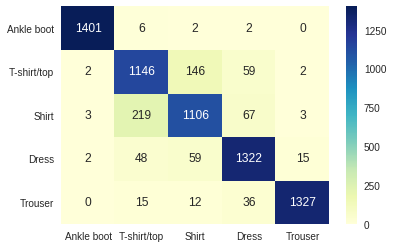

n_iter:  10
bottle_neck_size :  50
***********************************
0 0.2353798649104228
100 0.044897791960689604
200 0.03329060468830326
300 0.027465235261883967
400 0.023996953556436048
Reached threshold


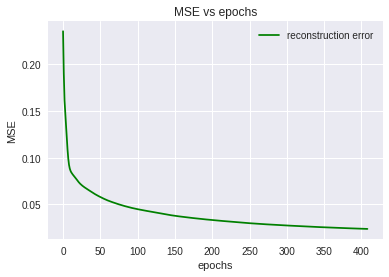

***********************************
number of epochs: 409
reconstruction error:  0.023790782848464437
***********************************
***********************************
bottle_neck_size :  24
***********************************
0 6.014053560394176
100 5.0469411519071175
200 4.905600013080551
300 4.809656749168513
400 4.735897691926114
500 4.678507807402393
600 4.630149493929994
700 4.592184336114328
800 4.565876061627468
900 4.54170728470975


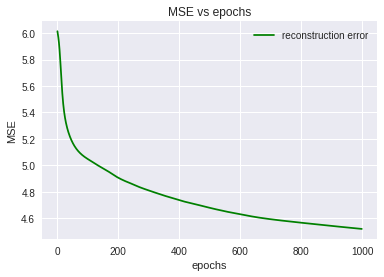

***********************************
number of epochs: 1000
reconstruction error:  4.51894917392008
***********************************
***********************************
bottle_neck_size :  11
***********************************
0 2.1760952706480103
100 1.717078708576177
200 1.6237942903157063
300 1.559492284402257
400 1.4940099664347883
500 1.45419905249896
600 1.4284705043431136
700 1.4064886982502514
800 1.3901700269460762
900 1.3762158221127962


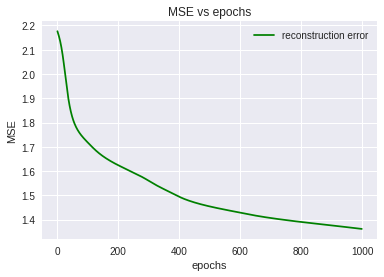

***********************************
number of epochs: 1000
reconstruction error:  1.3615782193260983
***********************************
***********************************
0 1.577612716725536
50 1.0308733799664647
100 0.9721788666425607
Reached threshold
number of epochs: 132
train error:  0.9599734586271582
test error:  1.0093156324410884


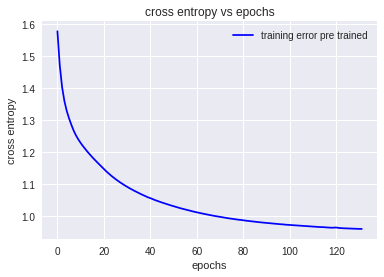

Train accuracy: 0.9525714285714286
Test accuracy: 0.9008571428571429


<Figure size 432x288 with 0 Axes>

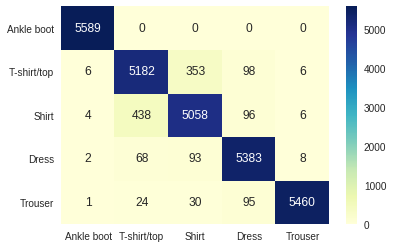

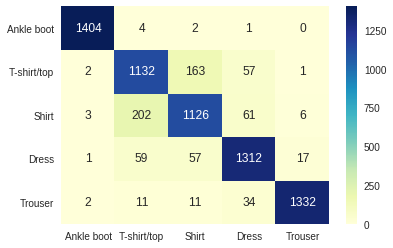

n_iter:  11
bottle_neck_size :  25
***********************************
0 0.23501154195074242
100 0.0444760346918486
200 0.034406450461244124
300 0.03040526294293882
Reached threshold


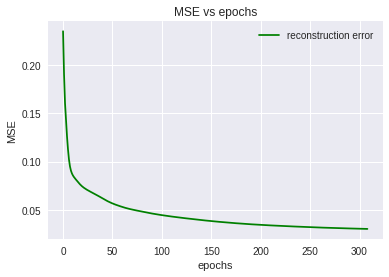

***********************************
number of epochs: 309
reconstruction error:  0.03020325103852655
***********************************
***********************************
bottle_neck_size :  12
***********************************
0 12.814040076386716
100 11.490071322380189
200 11.264652339004725
300 11.078495132054226
400 10.9855513642347
500 10.92304787252763
600 10.82507363818179
700 10.766730355718476
800 10.726069475170892
900 10.673905549814199


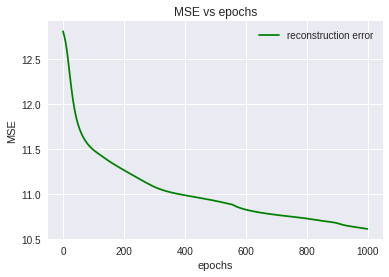

***********************************
number of epochs: 1000
reconstruction error:  10.610173409188784
***********************************
***********************************
bottle_neck_size :  5
***********************************
0 4.636822897135252
100 4.06184978643814
200 3.790893238026684
300 3.6488895051389876
400 3.530671370551125
500 3.4445430129671277
600 3.381368672886786
700 3.3316322916995085
800 3.288215433273828
900 3.2352158815625094


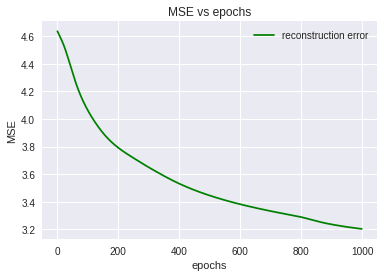

***********************************
number of epochs: 1000
reconstruction error:  3.2024093357293424
***********************************
***********************************
0 1.5419410570075605
50 1.1350790508839652
100 1.0332501693933795
150 0.9891092172421941
Reached threshold
number of epochs: 156
train error:  0.9869220135082557
test error:  1.0375927758498882


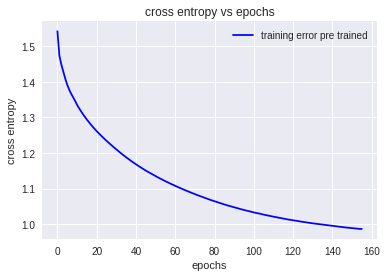

Train accuracy: 0.95625
Test accuracy: 0.8984285714285715


<Figure size 432x288 with 0 Axes>

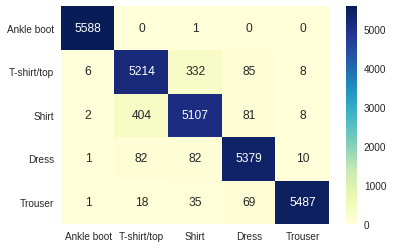

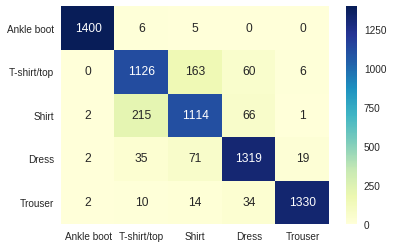

In [0]:
### Experiment ###
bottle_neck_size_list = [500,450,400,350,300,250,200,150,100,50,25]
for i in range(len(bottle_neck_size_list)):
  print('n_iter: ', i+1)
  classifier, _ , _ = StackedAE_MLFFNN(x_train, y_train, x_test, y_test, 
                                learning_rate = 1e-4, max_epoch = 1000, 
                                error_threshold = 1e-4, bottle_neck_size =bottle_neck_size_list[i] )

In [0]:
torch.cuda.is_available()

True

In [0]:
device

device(type='cuda', index=0)

In [0]:
x_train_torch.

torch.Tensor

In [0]:
################# Simple MLFFNN  #########################
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)


    
def Simple_MLFFNN(x_train, y_train, x_test, y_test, learning_rate, max_epoch, error_threshold, bottle_neck_size): 
  
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  torch.set_default_tensor_type('torch.DoubleTensor')
  dtype = torch.int64

  #make torch tensors 
  x_train_torch = torch.tensor(x_train,dtype=torch.double); 
  x_train_torch = x_train_torch.to(device)
  y_train_torch = torch.tensor(y_train, dtype=dtype)
  y_train_torch = y_train_torch.to(device)
  
  x_test_torch = torch.tensor(x_test,dtype=torch.double); 
  x_test_torch = x_test_torch.to(device)
  y_test_torch = torch.tensor(y_test, dtype=dtype)
  y_test_torch = y_test_torch.to(device)
  
  D_IN = x_train.shape[1]
  BOTTLENECK_SIZE = bottle_neck_size
  D_OUT = 5
  LEARNING_RATE = learning_rate
  MAX_EPOCH = max_epoch
  THRESHOLD = error_threshold
  
  AE1,bottle_neck1,AE2,bottle_neck2,AE3, bottle_neck3 = Stacked_AEs(bottle_neck_size = BOTTLENECK_SIZE)
  
  print('bottle_neck1 size:',bottle_neck1,'\nbottle_neck2 size:',bottle_neck2,'\nbottle_neck3 size:',bottle_neck3)
  
  
  train_loader = torch.utils.data.DataLoader(ConcatDataset(x_train_torch,y_train_torch), batch_size= 2048, shuffle=False)
  
  classifier = torch.nn.Sequential(AE1.encoder,AE2.encoder,AE3.encoder,torch.nn.Linear(bottle_neck3, 5),
                                   torch.nn.Softmax())  
  #del AE1,AE2,AE3
  classifier = classifier.to(device)
  
  
  
  
  loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
  optimizer = torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
  error_train = []
  accuracy = []
  ##### Training ##############
  for epoch in range(MAX_EPOCH):
    batch_loss = []
    for data in train_loader: 
    
    
      y_pred_train = classifier(x_train_torch)        
      loss_train = loss_fn(y_pred_train, y_train_torch)
      batch_loss.append(loss_train.item())
      
      optimizer.zero_grad()
      loss_train.backward()
      optimizer.step()
     
    ##########
    y_pred_test = classifier(x_test_torch) 
    prediction_test = y_pred_test.cpu().detach().numpy()
    prediction_test = prediction_test.argmax(axis = 1)
    acc = accuracy_score(y_test, prediction_test)
    accuracy.append(acc.item())
    ###############
    mean_batch_loss = np.mean(batch_loss)
    del batch_loss
    if epoch % 50 == 0:
        print(epoch, mean_batch_loss.item())    
    error_train.append(mean_batch_loss.item())

    #early stopping criteria
    if epoch >= 5 and abs(error_train[epoch-1] - error_train[epoch]) <= THRESHOLD:
      print('Reached threshold')
      break

  
  
  print('number of epochs:', len(error_train))
  print('train error: ', error_train[-1])
  #test accuracy
  y_pred_test = classifier(x_test_torch)        
  loss_test = loss_fn(y_pred_test, y_test_torch)
  test_error = loss_test.cpu().item()
  print('test error: ', test_error)
  
  
  plt.plot(error_train, color = 'b', label = 'training error random initialization')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('cross entropy')
  plt.title('cross entropy vs epochs')
  plt.show()
  
  
  
  prediction_train = y_pred_train.cpu().detach().numpy()
  prediction_train = prediction_train.argmax(axis = 1)
  acc = accuracy_score(y_train, prediction_train)
  fig3 = plt.figure(3)
  print('Train accuracy:', acc)

  #test accuracy
  y_pred_test = classifier(x_test_torch)        
  loss_test = loss_fn(y_pred_test, y_test_torch)
  ##################
  prediction_test = y_pred_test.cpu().detach().numpy()
  prediction_test = prediction_test.argmax(axis = 1)
  acc = accuracy_score(y_test, prediction_test)
  print('Test accuracy:', acc)

  #Confusion matrix
  heat_map(y_train, prediction_train, y_test, prediction_test)

  return classifier,accuracy,error_train

In [0]:
### Experiment #######
bottle_neck_size_list = [500,450,400,350,300,250,200,150,100,50,25]
for i in range(len(bottle_neck_size_list)):
  print('n_iter: ',i)
  classifier, _ , _ = Simple_MLFFNN(x_train, y_train, x_test, y_test, 
                                learning_rate = 1e-4, max_epoch = 1000, 
                                error_threshold = 1e-4, bottle_neck_size = 100)

bottle_neck1 size: 100 
bottle_neck2 size: 49 
bottle_neck3 size: 24


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.6026414079556506
50 1.0090058818831016
100 0.981744460169262
Reached threshold
number of epochs: 137
train error:  0.9759470776723264
test error:  1.0159941061824989


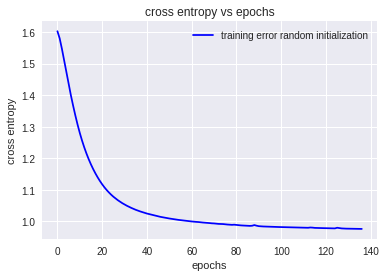

Train accuracy: 0.9312142857142857
Test accuracy: 0.8908571428571429


<Figure size 432x288 with 0 Axes>

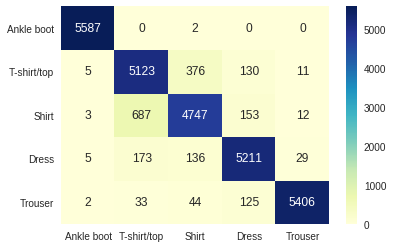

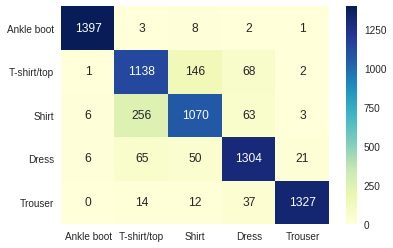

In [0]:
classifier, _ , _ = Simple_MLFFNN(x_train, y_train, x_test, y_test, 
                                learning_rate = 1e-4, max_epoch = 1000, 
                                error_threshold = 1e-4, bottle_neck_size = 100)

bottle_neck_size :  25
***********************************
0 0.23386346209274259
100 0.04477305430192602
200 0.03436418770491195
300 0.030356088790201706
Reached threshold


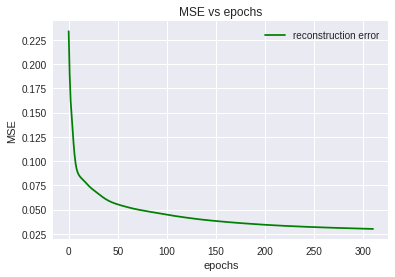

***********************************
number of epochs: 311
reconstruction error:  0.030100682625452423
***********************************
***********************************
bottle_neck_size :  12
***********************************
0 12.712283425452085


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


100 11.413548880430309
200 11.127677945096028
300 10.934817376554404
400 10.792739527298378
500 10.710799270478802
600 10.644305236893072
700 10.574953462001458
800 10.525170006588926
900 10.487132222179891


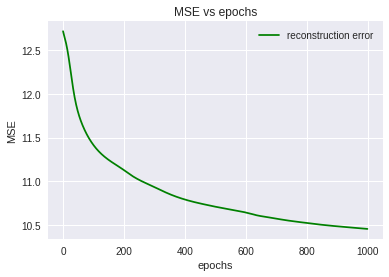

***********************************
number of epochs: 1000
reconstruction error:  10.457534312789848
***********************************
***********************************
bottle_neck_size :  5
***********************************
0 3.828567997151473
100 3.3684221410482444
200 3.1314896420687357
300 2.9776565939932014
400 2.873558447129425
500 2.8031397546061867
600 2.7552254735554134
700 2.7206569857369334
800 2.693379566171093
900 2.6703971209074147


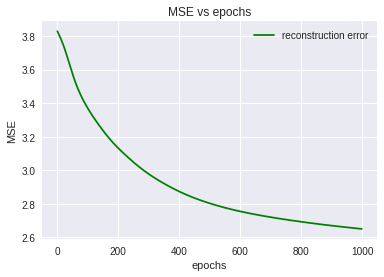

***********************************
number of epochs: 1000
reconstruction error:  2.6507978236262635
***********************************
***********************************


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.546264782411767
50 1.1387914230865828
100 1.0199152182402724
150 0.9756741269947702
200 0.9580014141638146
250 0.9493549002383588
300 0.9447256613675709
350 0.9418311346669703
400 0.9399842867161927
450 0.9383122182073819
500 0.9373457943276456
550 0.9476231063592356
600 0.9360508237608541
650 0.9356209392699059
700 0.9351628800499624
750 0.9347210403242812
800 0.9342184973676336
850 0.9339625634713863
900 0.9337579729501867
950 0.933559005901805
number of epochs: 1000
train error:  0.9339723313134486
test error:  1.0058757878467637


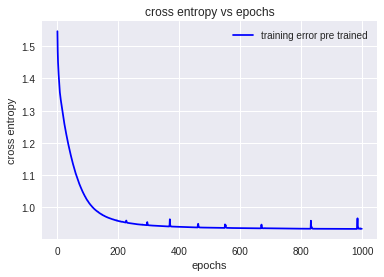

Train accuracy: 0.9711071428571428
Test accuracy: 0.8981428571428571


<Figure size 432x288 with 0 Axes>

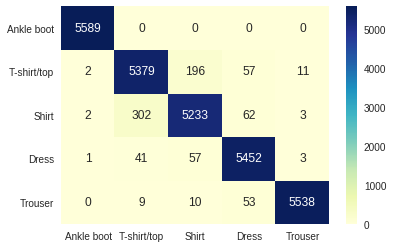

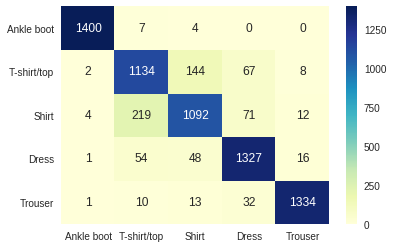

bottle_neck1 size: 25 
bottle_neck2 size: 12 
bottle_neck3 size: 5
0 1.6085803947776474
50 1.4574563246507124
100 1.2992757612211416
150 1.1894008410044432
200 1.1155977617866986
250 1.039688011487549
300 1.0032757139321369
350 0.9853918236349845
400 0.9758272925552072
450 0.9702165157353723
500 0.9669285542951345
550 0.964864867613948
600 0.9633113447168985
650 0.9619134936048063
700 0.9609054687908734
750 0.9603953106980937
800 0.9598405810601145
850 0.9596200762592476
900 0.9594381732182281
950 0.9593749902253835
number of epochs: 1000
train error:  0.959352563250733
test error:  1.0173555581235152


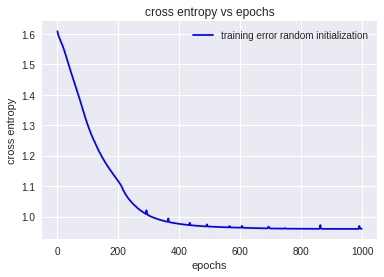

Train accuracy: 0.9454285714285714
Test accuracy: 0.887


<Figure size 432x288 with 0 Axes>

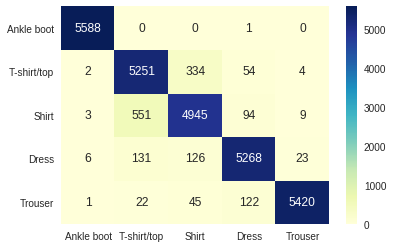

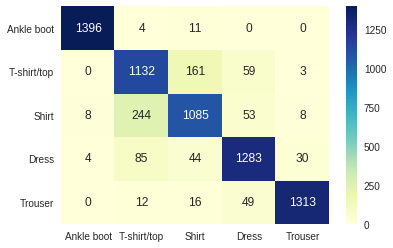

In [0]:
classifier, train_error_pre , test_accuracy_pre = StackedAE_MLFFNN(x_train, y_train, x_test, y_test, 
                                learning_rate = 1e-4, max_epoch = 1000, 
                                error_threshold = 0, bottle_neck_size = 25 )

classifier, train_error_rand , test_accuracy_rand = Simple_MLFFNN(x_train, y_train, x_test, y_test, 
                                learning_rate = 1e-4, max_epoch = 1000, 
                                error_threshold = 0, bottle_neck_size = 25)

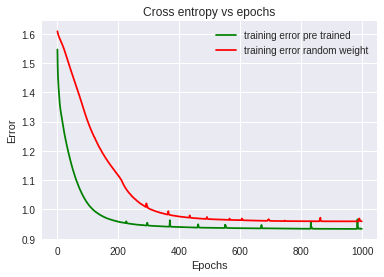

In [0]:
######### variable interchanged ############
plt.plot(test_accuracy_pre,  color = 'g', label = 'training error pre trained')
plt.plot(test_accuracy_rand[0:len(test_accuracy_pre)], color = 'r', label = 'training error random weight')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Cross entropy vs epochs')
plt.show()

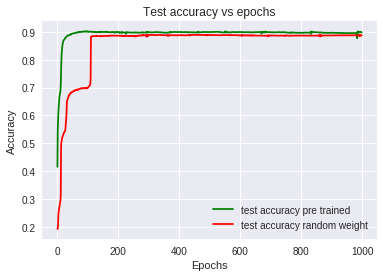

In [0]:
######### variable interchanged ############
plt.plot(train_error_pre, color = 'g', label = 'test accuracy pre trained')
plt.plot(train_error_rand[0:len(train_error_pre)], color = 'r', label = 'test accuracy random weight')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test accuracy vs epochs')
plt.show()